# Mnist Fashion으로 알아보는 Deep Learning

<img src="https://user-images.githubusercontent.com/77366857/120592063-2cb34d80-c478-11eb-8007-efbf53f7b667.png">

- Mnist Fashion Image란 운동화, 셔츠, 샌들과 같은 작은 이미지들의 모음입니다.
- 총 10 가지의 Class로 이루어져 있으며, 이미지는 28×28 픽셀이며 총 70,000 장으로로 이루어져 있습니다.
- 그 중 60,000장의 데이터는 Train 데이터이고, 10,000장은 Test 데이터입니다.
- 글창사에서 제공한 데이터에는 Test 데이터 대한 Label이 없으며 Test 데이터 Label을 예측하여 CSV파일로 제출하는 것이 실습 문제 입니다. 

## 0. Package Import
---

In [1]:
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

np.set_printoptions(threshold=np.inf, linewidth=500)

## 1. Data Load
---

In [2]:
y_train = np.array(pd.read_csv('Fashion_MNIST/train.csv')['class'])
y_test = pd.read_csv('./Fashion_MNIST/test_sample.csv')

- y label은 train.csv파일에 class라는 컬럼에 있습니다.
- y값은 id값의 순서대로 들어가져 있습니다.

In [3]:
train_path = './Fashion_MNIST/images/train/'
test_path = './Fashion_MNIST/images/test/'

X_train = np.array([mpimg.imread(train_path + str(i) + '.png') for i in range(0,60000)])
# for i in range(0,60000):
#     image_path = str(i) + '.png'
#     image = mpimg.imread(train_path + str(i) + '.png')
#     train_images.append(image)

X_test = np.array([mpimg.imread(test_path + str(i) + '.png') for i in range(0,10000)])
# for i in range(0,10000):
#     image_path = str(i) + '.png'
#     image = mpimg.imread(test_path + str(i) + '.png')
#     test_images.append(image)

- Train 데이터는 한장 한장 실제 이미지로 있습니다.
- 따라서 이미지를 불러오는데 별도의 전처리를 해야합니다.
- matplotlib의 image를 사용하여 불러왔고, 파일명이 곧 id이 이므로, 순서대로 가져오면 0번 ~ 6만번, 0번 ~ 1만번의 데이터를 가져옵니다.

In [4]:
X_train.shape, y_train.shape, X_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28))

- 불러온 데이터의 모양을 살펴보았습니다.
- X_train 데이터는 60000장에 28 by 28 데이터로 Chanel은 1개(생략되어있음)로 Gray 스케일 입니다.
- y_train 데이터는 X_train의 라벨입니다. 총 6만개의 데이터의 라벨로 구성되어 있습니다.
- Test 데이터는 y_test는 제공해주지 않아 없습니다.

## 2. 데이터 라벨링
---

In [5]:
mnist_fashion_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle Boot']

- Mnist Fashion Image의 라벨은 총 10가지로 0 ~ 9까지 구성되어 있으며, 각각의 숫자는 아래의 클래스를 의미합니다.
|Label|Class
|---|---
|0|T-shirt/top(티셔츠)
1|Trouser(바지)
2|Pullover(풀오버스웨터)
3|Dress(드레스)
4|Coat(코드)
5|Sandal(샌들)
6|Shirt(셔츠)
7|Sneaker(운동화)
8|Bag(가방)
9|Ankle boot(발목 부츠)

## 3. 데이터 시각화
---

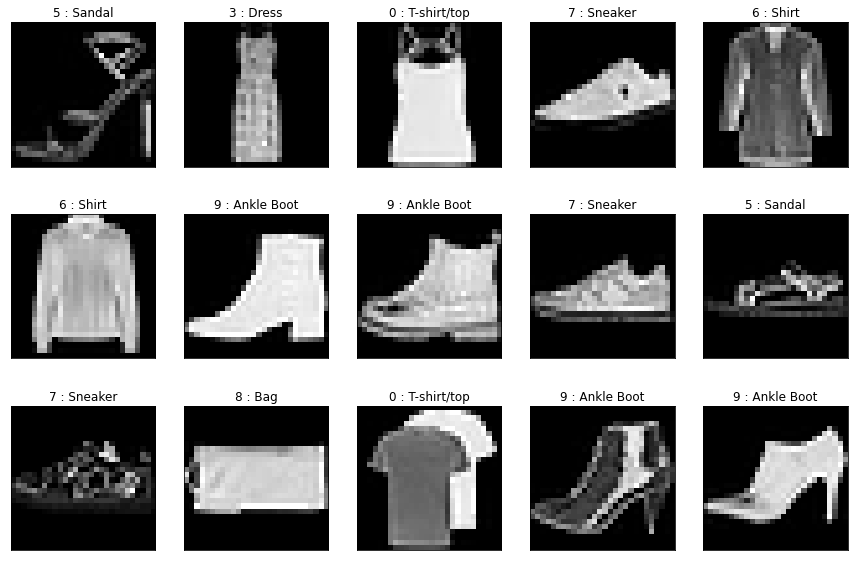

In [6]:
figure = plt.figure(figsize=(15, 10))
for index, i in enumerate(np.random.randint(0, X_train.shape[0], 15)):
    ax = figure.add_subplot(3, 5, index + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap = 'gray')
    ax.set_title(f"{y_train[i]} : {mnist_fashion_labels[y_train[i]]}")
plt.show()

- Train 데이터에서 랜덤하게 15개 데이터를 골라 시각화 하였습니다.
- 28 by 28의 1채널이라 화질이 그렇게 좋은 이미지는 아니지만, 눈으로 보아도 어떤 의류 사진인지 알수 있는것도 있으나, 아닌것도 있습니다.

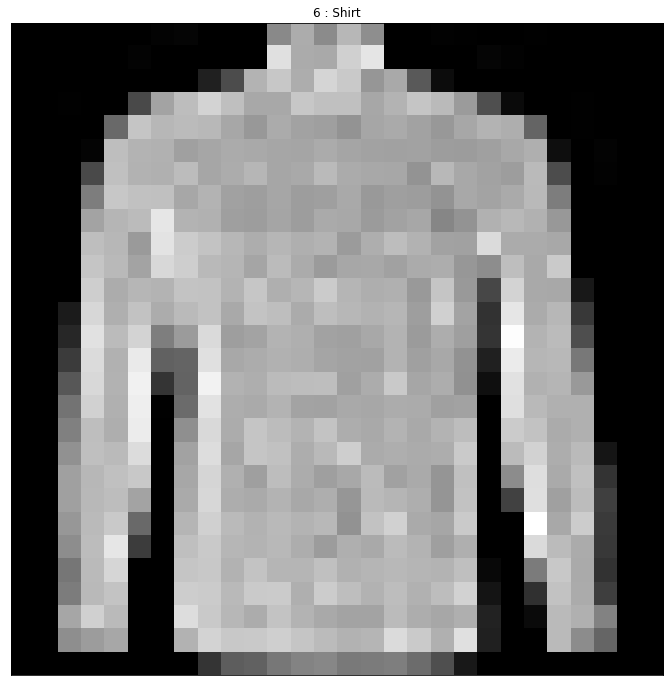

In [8]:
plt.figure(figsize=(12,12))
plt.imshow(X_train[8703], cmap ='gray')
plt.title(f'{y_train[8703]} : {mnist_fashion_labels[y_train[8703]]}')
plt.xticks([])
plt.yticks([])
plt.show()

- Train Data를 하나 골라 시각화 해보았습니다.
- 위의 이미지는 6번 Shirt(셔츠) 입니다.

In [21]:
print(X_train[8703] * 255)

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  11.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  59. 164. 220. 219. 222. 255. 252. 249. 247. 252. 255. 255. 221. 221. 227. 122.  23.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  88. 207. 244. 238. 229. 227. 228. 228. 228. 228. 227. 226. 229. 238. 239. 196.  39.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  98. 244. 231. 212. 233. 229. 224. 224. 226. 226. 229. 229. 234. 207. 238. 239.  71.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 204. 251. 213.  56. 255. 232. 236. 234. 235. 236. 237. 232. 255.  67. 219. 247. 200.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 211. 255. 200.   4. 255. 229. 234. 232. 233. 234. 234. 232. 255.   0. 216. 254. 201.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  20. 208. 255. 159.   0. 255. 232. 233. 231. 231. 231. 232. 235. 255.   0. 180. 255. 197.   2.   0.   0.   0.   0.]

- 위에서 그림으로 본 이미지를 Array 타입으로 보았습니다.
- 검은곳은 0이고 색깔이 있는 부분에 숫자가 있는것을 알수 있습니다.
- 이러한 숫자의 패턴으로 알고리즘들이 패턴을 찾고, 어떤 이미지인지 예측할수 있습니다.

## 4. 공통 데이터 처리
---

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.2, random_state = 87)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((48000, 28, 28), (12000, 28, 28), (48000,), (12000,))

- X_train 데이터 6만장을 실제 모델 학습 데이터와 검증 데이터로 나누겠습니다.
- 이렇게 학습 데이터를 나누는 이유는 가지고 있는 6만장의 데이터를 모두 모델 학습에 사용한다면 과적합이 올수 있습니다.
- 따라서 train 데이터에서 검증용 데이터와 학습용 데이터로 한번더 나누어서 모델 학습은 학습용 데이터에서 만합니다.
- 이후 생성된 모델을 검증용 데이터로 모델의 성능을 확인 합니다.
- 모델 성능이 확인되면 마지막으로 제출해야할 실제 y값이 없는 테스트 데이터를 예측 후 해당 결과를 csv파일로 저장하여 제출합니다.
- 즉, 6만장 데이터를 4만8천장의 모델 학습용 데이터와, 1만 2천장의 모델 검증용 데이터로 나누어 모델을 생성 한 후 생성된 모델을 1만장의 test 데이터를 예측합니다. 

In [11]:
unique, counts = np.unique(y_valid, return_counts=True)
dict(zip(unique, counts))

{0: 1200,
 1: 1200,
 2: 1200,
 3: 1200,
 4: 1200,
 5: 1200,
 6: 1200,
 7: 1200,
 8: 1200,
 9: 1200}

In [12]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 4800,
 1: 4800,
 2: 4800,
 3: 4800,
 4: 4800,
 5: 4800,
 6: 4800,
 7: 4800,
 8: 4800,
 9: 4800}

- 또한 split 과정에서 stratify 옵션을 넣어 label의 class가 모두 동일한 비율로 들어가게 만들었습니다.

In [13]:
X_train.min(),  X_train.max()

(0.0, 1.0)

- 제공받은 데이터는 이미 MinMax Scaler가 적용되어 있어, 따로 Scale을 하지 않습니다.

## 5. Machine Learning 기법을 사용하여 예측하기
---

### 5.1 머신러닝을 위한 데이터 처리

In [14]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=87)
X_train_reshape = X_train.reshape(X_train.shape[0], 28 * 28) # 48000, 784
X_valid_reshape = X_valid.reshape(X_valid.shape[0], 28 * 28) # 12000, 784
X_test_reshape = X_test.reshape(X_test.shape[0], 28 * 28) # 10000, 784

- 머신러닝을 하기전에 28 by 28의 데이터를 flatten하게 48000 * 784와 12000 * 28형식으로 reshape 해주었습니다. 
- 즉, 6만개의 데이터가 있고 총 784개의 특성이 있는 형식입니다.
- 또한 검증을 위해 StratifiedKFold를 생성합니다.

### 4.2 DecisionTree

In [15]:
clf = DecisionTreeClassifier(random_state=87)
cv_score = cross_val_score(clf, X_train_reshape, y_train, cv = skfold)
print('\nAccuracy: {:.4f}'.format(cv_score.mean()))


Accuracy: 0.7900


- 가장 먼저 DecisionTree로 학습해보았습니다.
- KFold로 검증한 평균 Accuracy는 0.79정도가 나옵니다.

In [16]:
clf.fit(X_train_reshape, y_train)
print('\nAccuracy: {:.4f}'.format(clf.score(X_valid_reshape, y_valid)))


Accuracy: 0.7896


- Decision Tree를 사용하여 검증결과 Accuracy는 0.7896정도 입니다.
- 생각보다 수치가 낮습니다.

In [17]:
clf_predict = clf.predict(X_test_reshape)
y_test_clf = y_test.copy()
y_test_clf['class'] = clf_predict
y_test_clf.to_csv('./Fashion_MNIST/clf_test.csv', index = False)

- 위에서 학습한 Decision Tree 모델을 Test 데이터에 적용하여 예측한 결과를 keyonbit_clf_test.csv파일로 저장합니다.

### 5.3 RandomForest

In [18]:
rf = RandomForestClassifier(random_state = 87)
cv_score = cross_val_score(rf, X_train_reshape, y_train, cv = skfold)
print('\nAccuracy: {:.4f}'.format(cv_score.mean()))


Accuracy: 0.8799


- 이번엔 RandomForest를 사용하여 예측합니다.
- RandomForest는 Decision Tree들이 모인 앙상블 기법입니다.
- 보통 Decision Tree보다 성능이 좋은것으로 알려져 있습니다.
- KFold를 진행하여, 평균 Accuracy를 확인해보니 0.8799가 나옵니다. 확실히 Decision Tree보다 높은 성능입니다.

In [19]:
rf.fit(X_train_reshape, y_train)
print('\nAccuracy: {:.4f}'.format(rf.score(X_valid_reshape, y_valid)))


Accuracy: 0.8805


- 생성한 모델을 검증 데이터로 Accuracy를 확인한 결과 0.8805 나옵니다.
- 나쁘지 않은 Accuracy로 보이지만, 다른 알고리즘도 해봐야겠습니다.

In [20]:
rf_predict = rf.predict(X_test_reshape)
y_test_rf = y_test.copy()
y_test_rf['class'] = rf_predict
y_test_rf.to_csv('./Fashion_MNIST/rf_test.csv', index = False)

- 위에서 학습 및 검증한 Random Forest 모델을 Test 데이터에 적용하여 예측한 결과를 keyonbit_rf_test.csv파일로 저장합니다.

## 5. Deep Learning을 사용하여 예측하기

---
### 5.1 Deel Learning을 위한 데이터 처리

In [20]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, 10)

- keras의 유틸을 사용하여, y 라벨을 one-hot encoding 해줍니다.
- One-Hot encodig이란 *9* 라고 표현된 라벨을 [0,0,0,0,0,0,0,0,0,1]의 벡터로 바꾸어주는 것입니다.
- Deep Learning은 각 클래스별로 확률을 출력해주기 때문에 꼭 필요한 작업 입니다.

### 6.2 Multi Layer Perceptron

In [38]:
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28)),
    tf.keras.layers.Dense(1000, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(800, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(500, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(300, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax'),
])

- keras를 사용하여 Layer를 쌓습니다.
- 처음 input은 train 데이터인 (48000, 28, 28)입니다.
- 위의 28, 28 데이터를 평평하게 (flatten) 784로 바꾸어 줍니다.
- 이후 1000 -> 800 -> 500 -> 300 -> 200 -> 100 -> 50으로 레이어가 생기고 나중엔 10개의 layer를 출력합니다. 해당 10개는 y라벨의 갯수 즉, class의 종류입니다.
- 마지막 layer에 softmax 활성화 함수를 사용하여 10개의 output에 대한 확률값을 출력하고, 가장 높은값을 예측값으로 사용합니다.

In [39]:
mlp_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dropout_17 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 800)               800800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 500)               400500    
_________________________________________________________________
dropout_19 (Dropout)         (None, 500)              

- 위에서 생성한 모델의 summary입니다.
- layer는 각 층에서 행하는 type이고, output shape는 해당 층을 거치면 나오게 되는 output에 대한 size 입니다.
- Param은 해당 layer에서 가치는 파라미터 수의 입니다.
- Param = (입력 데이터 차원 + 1) * 뉴런 수 입니다. (1 씩 증가하는 이유는 각 뉴런에 바이어스가 있기 때문입니다.) ex : dense = (784 +1) * 392 = 307720개

In [40]:
mlp_model.compile(optimizer = 'Adam', loss='categorical_crossentropy', metrics=['accuracy'])

- loss : 손실함수, 모델의 최적화에 사용되는 목적함수입니다. 모델과 데이터 분류종류에 따라 MSE, categorical_crossentropy, sparse_categorical_crossentropy, binary_crossentropy 등 이 있습니다.
- optimizer : 최적의 가중치를 검색하는 데 사용되는 최적화 알고리즘. adam이 대표적입니다.
- metrics : 모델의 성능을 저장하는 지표, 리스트 형태로 여러개도 저장가능합니다.

In [41]:
checkpoint = ModelCheckpoint(filepath='model.weights.best.mlp.develop.hdf5', verbose=0, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=50)
mlp_history = mlp_model.fit(X_train, y_train_one_hot, epochs=500, batch_size=500,
                            validation_split=0.2, callbacks=[checkpoint, earlystopping], verbose=0)

- 위에서 생성한 MLP모델을 학습 시켰습니다.
- batch : 전체 데이터셋 중 batch의 크기만큼 학습시키것을 의미합니다.
- epochs : 전체 데이터셋을 학습시키는 수입니다.
- ModelCheckpoint : epoch마다 성능이 좋아지면 모델을 저장합니다.(model.weights.best.mlp.develop.hdf5 라는 이름으로 저장됨)
- EarlyStopping : epoch 마다 설정한 성능이 좋아지지 않으면 자동으로 학습을 종료시킵니다. 위에서는 val_loss 이며, epoch 20회동안 나아지지 않으면 멈춥니다.
- validation_split : 입력받은 데이터의 20%를 사용하여 매 epochs 마다 검증을 실행합니다.

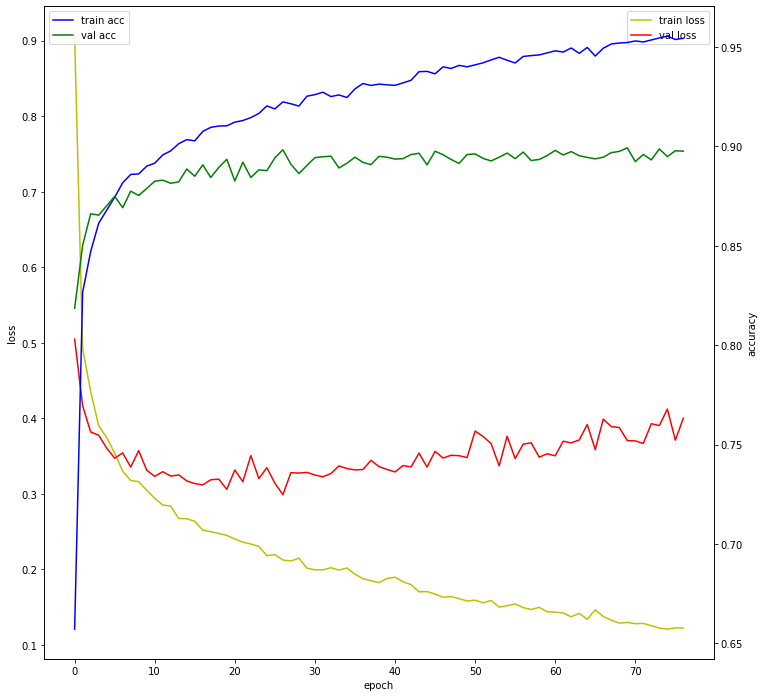

In [42]:
fig, loss_ax = plt.subplots(figsize=(12, 12))
acc_ax = loss_ax.twinx()

loss_ax.plot(mlp_history.history['loss'], 'y', label='train loss')
loss_ax.plot(mlp_history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

acc_ax.plot(mlp_history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(mlp_history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

- 모델 학습 대한 지표입니다.
- 그래프를 보면 epoch가 늘어날때마다 학습 데이터의 loss는 줄어드는데, 검증 데이터의 loss는 점점 늘어나고 있습니다.
- 더이상 검증 loss가 줄지 않아 early stopping이 적용되어 약 80 epoch전에 학습이 종료된것으로 보입니다.

In [43]:
mlp_model.load_weights('model.weights.best.mlp.develop.hdf5')
print('\nAccuracy: {:.4f}'.format(mlp_model.evaluate(X_valid, y_valid_one_hot)[1]))

375/375 [==============================] - 0s 885us/step - loss: 0.3000 - accuracy: 0.8953

Accuracy: 0.8953


- load_weights로 가장 학습이 잘된 모델의 가중치를 가져와서 검증을 해봅니다.
- Accuracy는 0.8953로 사실 RandomForest보다는 조금 큰 성능을 보여줍니다.

In [44]:
mlp_predict = np.argmax(mlp_model.predict(X_test), axis=-1)
y_test_mlp = y_test.copy()
y_test_mlp['class'] = mlp_predict
y_test_mlp.to_csv('./Fashion_MNIST/mlp_test.csv', index = False)

- 위에서 만든 mlp 모델을 사용하여 제공받은 test 데이터를 가지고 예측을 하였고, csv 파일로 저장하였습니다.

### 6.3 Convolution Neural Network

In [45]:
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_valid_cnn = X_valid.reshape(X_valid.shape[0], 28, 28, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28, 1)

- cnn 모델에 넣기 위해 data를 reshape 해줍니다.
- 사진이미지를 넣을때 마지막에 1인 chanel입니다. Mnist Fashion image는 gray scale이므로 1채널이라, 마지막에 1을 붙여줍니다.

In [46]:
cnn_model = tf.keras.Sequential([
    keras.layers.Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (28, 28, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(filters = 128, kernel_size = 2, padding = 'same', activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(filters = 128, kernel_size = 2, padding = 'same', activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(), # Flaatten으로 이미지를 일차원으로 바꿔줌
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation = 'softmax')
])

- **input_shape** : 샘플 수를 제외한 입력 형태를 정의 합니다. 모델에서 첫 레이어일 때만 정의하면 됩니다. (행, 열, 채널 수)로 정의합니다. 흑백영상인 경우에는 채널이 1이고, 컬러(RGB)영상인 경우에는 채널을 3으로 설정합니다.
- **activation** : 활성화 함수를 설정
    - linear : 디폴트 값, 입력뉴런과 가중치로 계산된 결과값이 그대로 출력으로 나옵니다.
    - relu : rectifier 함수, 은익층에 주로 쓰입니다. 0이하는 0으로 만들고 그 이상은 그대로 출력합니다.
    - sigmoid : 시그모이드 함수, 이진 분류 문제에서 출력층에 주로 쓰입니다. 0 혹은 1로 출력합니다.
    - softmax : 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 주로 쓰입니다. 0과 1사이의 값으로 출력되며, 모두 더한값은 1이 되므로, 확률처럼 사용합니다.
- **filter(kernel)** : 이미지의 특징을 찾기위한 파라미터, 해당 filter가 이미지를 움직이며 특징을 잡아냄, 해당 특징이 featuremap, filter의 종류에 따라 가로선 filter, 세로선 filter등이 있는데 cnn에선 해당 필터를 자동으로 생성함
- **featuremap** : input 이미지에서 filter로 만들어진 해당 이미지의 특성을 가진 map
- **filters** : input 이미지에서 featuremap을 생성 하는 filter의 갯수
- **padding** : 외곽의 값을 0으로 채워넣어서 filter들로 만들어진 featuremap 기존의 이미지의 크기와 같게 할지의 여부 same은 같게, valid는 다르게, same으로 하면 filter가 이미지 사이즈에 맞게 featuremap을 만듬.
- **pooling** : 계속 filter가 이미지를 움직이며 featuremap을 만들고 paddind이 same이라면 계속 같은 크기의 featuremap이 생성되게 됨. 이를 방지하기 위해 pooling 레이어를 거쳐 이미지 사이즈를 줄임, pool_size는 이미지에서 줄여지는 값
    - maxpooling : pooling 영역에서 가장 큰 값만 남기는것
    - averagepoolig : pooling 영역의 모든 데이터의 평균값을 구하여 남김
- **dropout** : 이미지의 일부분을 drop시켜 학습하는데 어려움을 줌, 이로 인해 과적함을 막을 수 있습니다.
- **flatten** : 앞에서 만든 (7, 7, 64)의 배열을 7 * 7 * 64하여  3136의 1줄의 배열로 평평하게 만드는것 입니다.
    - (2번의 pooling으로 이미지 사이즈가 작아짐, 28, 28, 64 -> 14, 14, 64 -> 7, 7, 64)
- **dense** : 평평한 데이터가 들어오면, 해당 데이터를 dense레이어를 지나 맨앞의 사이즈로 줄여줌, 마지막은 10개 사이즈가 나오고, 이를 softmax함수로 활성화하여 0 ~ 9까지의 클래스를 예측할수 있게 해줍니다.


In [47]:
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        16448     
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)         

- cnn_model의 summary입니다. 지금은 모델이 크지 않으니 그렇지만, 나중에 더 큰 모델을 만든다면 꼭 summary를 봐야 합니다.

In [48]:
cnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

- 모델을 컴파일해줍니다.

In [49]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.cnn.hdf5', verbose=0, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=50)
history = cnn_model.fit(X_train_cnn, y_train_one_hot, batch_size=500, epochs=500, verbose=0, validation_split=0.2, callbacks=[checkpointer, earlystopping])

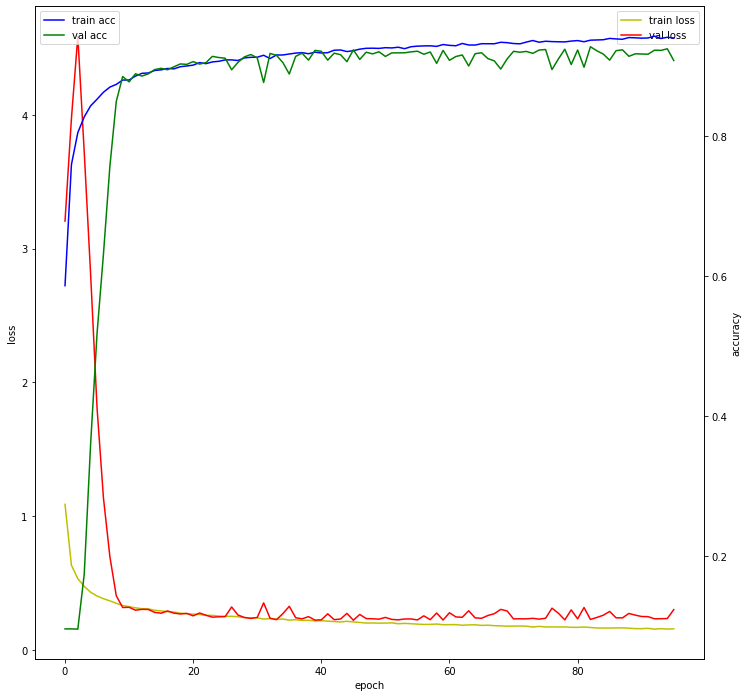

In [50]:
fig, loss_ax = plt.subplots(figsize=(12, 12))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

- 앞에서 학습했던 MLP 모델과 비교하여 loss도 굉장히 잘 떨어지고, train과 valid간의 차이도 많이 없어보입니다.
- accuracy도 train과 valid간에 오르는것이 보입니다.
- 성능을 기대해봐도 좋을듯 합니다.

In [51]:
cnn_model.load_weights('model.weights.best.cnn.hdf5')
print('\nAccuracy: {:.4f}'.format(cnn_model.evaluate(X_valid_cnn, y_valid_one_hot)[1]))

375/375 [==============================] - 0s 1ms/step - loss: 0.2169 - accuracy: 0.9252

Accuracy: 0.9252


- CNN의 성능이 여태까지의 모델중에 좋게나왔습니다.
- MLP도 Accuracy가 0.9를 넘지못했는데, CNN은 0.9252로 0.9의 Acuuracy를 넘었습니다.
- 확실히 이미지쪽은 CNN이 좋은듯 합니다.

In [52]:
cnn_predict = np.argmax(cnn_model.predict(X_test_cnn), axis=-1)
y_test_cnn = y_test.copy()
y_test_cnn['class'] = cnn_predict
y_test_cnn.to_csv('./Fashion_MNIST/cnn_test.csv', index = False)

- 마지막으로 CNN의 모델로 X_test 데이터를 예측 한뒤 cnn_test.csv에 저장합니다.

## 7. 회고
---
- CNN Model의 Test Data를 제출할 예정입니다. 
- 마지막 스코어인 0.92 근방의 Accuracy가 나오지 않을까 예상합니다. 
- 데이터도 분리해서 검증도 잘했고, 과적합도 아닌것으로 파악되기 때문 입니다.
- 향후 Deep Learning 관련 학습을 더 진행하여 CNN 모델을 개선시키고 싶습니다.